In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from cv2 import aruco
import math
import shutil
from scipy.spatial.transform import Rotation as R
from pyquaternion import Quaternion
import math
import json

In [2]:
class Transporter:
    def __init__(self):
        #self.point_cloud_math = PointCloudMath()
        #self.transporter_width = TRANSPORTER_SIZE_IN_METERS.get('width')
        #self.transporter_height = TRANSPORTER_SIZE_IN_METERS.get('height')
        #self.transporter_length = TRANSPORTER_SIZE_IN_METERS.get('length')

        self.aruco_dict = cv2.aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
        self.parameters = cv2.aruco.DetectorParameters()
        self.ar_detector = cv2.aruco.ArucoDetector(self.aruco_dict, self.parameters)

    def estimate_arucos_poses(
        self, 
        image,
        intrinsic,
        distortion_coef,
        marker_size,
        aruco_corners,
        correct_rot_mat=np.eye(3)):
        """
        Estimate the pose of ArUco markers in the image.
        Parameters:
            image: Input image containing ArUco markers.
            intrinsic: Camera intrinsic matrix.
            distortion_coef: Distortion coefficients of the camera.
            marker_size: Size of the ArUco marker in meters.
            aruco_corners: Detected corners of the ArUco markers.
            correct_rot_mat: Rotation matrix to correct the orientation of the markers.
        Returns:
            rvecs: List of rotation vectors for each detected marker.
            tvecs: List of translation vectors for each detected marker.
        """

        rvecs, tvecs = [], [] 
    
        for i in range(len(aruco_corners)):
            rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
                aruco_corners[i], 
                marker_size, 
                intrinsic, 
                distortion_coef)
            r_mat, _ = cv2.Rodrigues(rvec)
    
            # The aruco is rotated about z-axis, we need to adjust the rotation matrix. If 
            # it is pasted correctly, just multiply with identity matrix.
            r_mat_correct = r_mat @ correct_rot_mat
            r_vec_correct, _ = cv2.Rodrigues(r_mat_correct)
    
            rvecs.append(r_vec_correct)
            tvecs.append(tvec)
                 
        return rvecs, tvecs

    def detect_aruco_markers_by_id(
        self, 
        image,
        selected_aruco_ids,
        BGR_format=True):
        """
        Detect ArUco markers in the image by their IDs.
        Parameters:
            image: Input image containing ArUco markers.
            selected_aruco_ids: List of ArUco marker IDs to detect.
            BGR_format: If True, the input image is in BGR format, otherwise RGB.
        Returns:
            boxes: List of bounding boxes for detected markers.
            centers: List of centers of the detected markers.
            selected_corners: List of corners for the detected markers.
        """

        boxes = []
        centers = []
        selected_corners = []
        gray_img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)

        corners, ids, _ = self.ar_detector.detectMarkers(gray_img)

        if ids is None:
            return boxes, centers, selected_corners
            
        for i, marker_id in enumerate(ids.flatten()):
            if marker_id in selected_aruco_ids:
                x_coords = corners[i][0][:, 0]
                y_coords = corners[i][0][:, 1]
                x1, y1 = int(np.min(x_coords)), int(np.min(y_coords))
                x2, y2 = int(np.max(x_coords)), int(np.max(y_coords))
                center = ((x1+x2)//2, (y1+y2)//2)
                boxes.append(((x1, y1, x2, y2), f'ArUco_{marker_id}', 1.0))
                centers.append(center)
                selected_corners.append(corners[i])
                
        return boxes, centers, selected_corners

    def detect_obstacles(self, depth_map, depth_thresh=0.5, obstacle_thresh=0.1):
        """
        Detect obstacles in the depth map.
        Parameters:
            depth_map: Input depth map.
            threshold: Threshold for obstacle detection.
        Returns:
        """

        depth_map = depth_map[:depth_map.shape[0] // 2, :]
        binary_mask = np.zeros_like(depth_map, dtype=np.uint8)
        depth_map[depth_map == 0] = np.median(depth_map[depth_map > 0])  # Replace 0 with median of non-zero values 
        binary_mask[depth_map < depth_thresh] = 1
        binary_mask[depth_map >= depth_thresh] = 0
        if len(binary_mask[binary_mask == 1]) / binary_mask.size > obstacle_thresh:
            return True
        return False

    def detect_obstacles_from_pointcloud(
        self, 
        color_frame,
        depth_map, 
        camera_intrinsic,
        depth_thresh=0.5, 
        obstacle_thresh=0.1,
        is_transporter_lifting=False,
        lifted_object_size=None):
        """
        Detect obstacles from the point cloud. The point cloud is in the robot coordinate
        Parameters:
            depth_map in millimeter unit
        Returns:
            bool: True if obstacles are detected, False otherwise.
        """

        y_offset_from_robot_to_camera = ROBOT_TO_CAMERA_TRANS_MAT[1, -1] 
        depth_thresh = depth_thresh + y_offset_from_robot_to_camera  
        offset = 0.005
        height_thresh = self.transporter_height - CAMERA_SHIFT_FROM_GROUND + offset
        width_thresh = self.transporter_width / 2

        if is_transporter_lifting:
            assert lifted_object_size is not None
            lifted_object_length = lifted_object_size.get("length")
            depth_thresh = depth_thresh + self.calculate_add_on_length(lifted_object_length)

        pcl = self.point_cloud_math.rgbd_to_projection(
            color_frame, 
            depth_map, 
            camera_intrinsic)

        points = np.asarray(pcl.points)  # (N, 3)
        colors = np.asarray(pcl.colors)
        assert points.ndim == 2 and points.shape[-1] == 3, "Incorrect shape of 'points'!!!"

        points_in_cam_coord = np.ones((points.shape[0], 4), dtype=np.float32)  # (N, 4)
        points_in_cam_coord[:, :-1] = points
        points_in_robot_coord = ROBOT_TO_CAMERA_TRANS_MAT @ points_in_cam_coord.T  # (4, N)
        points_in_robot_coord = points_in_robot_coord.T  # (N, 4)
        points_in_robot_coord = points_in_robot_coord[:, :-1]  # (N, 3)

        not_ground_mask = points_in_robot_coord[..., -1] > 0
        pcl = o3d.geometry.PointCloud()
        pcl.points = o3d.utility.Vector3dVector(points[not_ground_mask])
        pcl.colors = o3d.utility.Vector3dVector(colors[not_ground_mask])
        points_in_robot_coord = points_in_robot_coord[not_ground_mask]

        num_points = points_in_robot_coord.shape[0]
        distance_mask = points_in_robot_coord[..., 1] < depth_thresh
        height_mask = points_in_robot_coord[..., 2] < height_thresh
        width_mask = np.bitwise_and(-width_thresh < points_in_robot_coord[..., 0], points_in_robot_coord[..., 0] < width_thresh)   

        if is_transporter_lifting:
            obstacle_mask = distance_mask
        else:
            obstacle_mask = width_mask & height_mask & distance_mask

        if np.sum(obstacle_mask) / num_points > obstacle_thresh:
            return True, obstacle_mask, pcl, points_in_robot_coord
        return False, obstacle_mask, pcl, points_in_robot_coord

    def calculate_add_on_length(self, carried_object_length):
        """
        Suppose that transporter is able to align in the middle of the carried object
        """
        assert carried_object_length > self.transporter_length
        return (carried_object_length - self.transporter_length) / 2

In [3]:
def resizeWithCropFactor(img, size, intrinsic=None):
    h1, w1 = img.shape[:2]
    w2, h2 = size
    if h1 == h2 and w1 == w2:
        return img, intrinsic 
    r1 = w1 / h1
    r2 = w2 / h2
    if r1 >= r2:
        changed_width = int(r2 * h1)
        offset_pxl_pos = int((w1 - changed_width) / 2)
        img = img[:, offset_pxl_pos : offset_pxl_pos + changed_width]
        ratio = h2 / h1
    elif r1 < r2:
        changed_height = int(w1 / r2)
        offset_pxl_pos = int((h1 - changed_height) / 2)
        img = img[offset_pxl_pos : offset_pxl_pos + changed_height, :]
        ratio = w2 / w1

    if intrinsic is not None:
        cx = w2 / 2
        cy = h2 / 2

        new_intrinsic = intrinsic.copy()
        new_intrinsic[0, -1] = cx
        new_intrinsic[1, -1] = cy
        new_intrinsic[0, 0] *= ratio
        new_intrinsic[1, 1] *= ratio
        return cv2.resize(img, (w2, h2)), new_intrinsic

    return cv2.resize(img, (w2, h2)), None

def rotationMatrixToEulerAngles(R):
    """
    Convert a rotation matrix to Euler angles (roll, pitch, yaw).
    """
    assert (R.shape == (3, 3))
    
    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    
    singular = sy < 1e-6
    
    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0
    
    return np.array([x, y, z])

def compute_angle(rmat):
    """Computes the angle from the rotation vector."""
    euler_angles = rotationMatrixToEulerAngles(rmat)
    angle = np.rad2deg(euler_angles)[1]
    angle = -angle
    return angle

def _draw_boxes_and_labels(
    image, 
    markers_corners, 
    matrix_coefficients,
    distortion_coefficients,
    rvecs,
    tvecs,
    device_depth=None, 
    device_angle=None, 
    device_shift=None, 
    midpoint=None):

    annotated_image = image.copy()

    #annotated_image = cv2.aruco.drawDetectedMarkers(annotated_image, markers_corners) 

    for rvec, tvec in zip(rvecs, tvecs):
        annotated_image = cv2.drawFrameAxes(
            annotated_image, 
            matrix_coefficients, 
            distortion_coefficients, 
            rvec, 
            tvec, 
            0.06) 
    
    # Position metrics display
    text_lines = [
        f"Depth: {device_depth:.1f} m",
        f"Angle: {device_angle:.1f} deg",
        f"Shift: ({device_shift[0]:.2f} m, {device_shift[1]:.2f}) m"]

    # Draw camera coordinate
    annotated_image = cv2.drawFrameAxes(
        annotated_image,
        matrix_coefficients,
        distortion_coefficients,
        rvec=cv2.Rodrigues(np.eye(3))[0], 
        tvec=np.array([0, 0, 1], dtype=np.float64),
        length=0.06)
    
    y_offset = 40
    for line in text_lines:
        text_size = cv2.getTextSize(line, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
        cv2.putText(annotated_image, line, 
                (midpoint[0], midpoint[1]-y_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        y_offset += text_size[1] + 10

    return annotated_image


In [4]:
des_dir = '/home/alan_khang/Downloads/guilder_dataset/raw_images'

src_dirs = [
    '/home/alan_khang/Downloads/Videos_30May/id_2/2025-05-30_12.01.14_rgb.mp4',
    '/home/alan_khang/Downloads/Videos_30May/under_cart/2025-05-30_18.46.56_rgb.mp4']

expected_size = (640, 400)

In [5]:
total_img_count = 0
img_count = 0

for video_path in src_dirs:
    cap = cv2.VideoCapture(video_path)
    skip_interval = 10

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if img_count % skip_interval == 0 and img_count != 0:
            #resized_frame = resizeWithCropFactor(frame, expected_size)[0]
            filename = os.path.join(des_dir, f'frame_{total_img_count:06d}.jpg')
            cv2.imwrite(filename, frame)
            total_img_count += 1

        img_count += 1

for fp in glob.glob(os.path.join(des_dir, 'captured*')):
    shutil.move(fp, os.path.join(des_dir, f'frame_{total_img_count:06d}.jpg'))
    total_img_count += 1

In [6]:
annotated_img_dir = '/home/alan_khang/Downloads/guilder_dataset/annotated_images'
annotated_dir = '/home/alan_khang/Downloads/guilder_dataset/annotations'
img_dir = '/home/alan_khang/Downloads/guilder_dataset/images'

transporter = Transporter()

if os.path.exists(annotated_img_dir):
    shutil.rmtree(annotated_img_dir)
os.makedirs(annotated_img_dir)
if os.path.exists(annotated_dir):
    shutil.rmtree(annotated_dir)
os.makedirs(annotated_dir)
if os.path.exists(img_dir):
    shutil.rmtree(img_dir)
os.makedirs(img_dir)

offset_px = 5

correct_rot_mat = np.array([
    [0., 1., 0.],
    [-1., 0., 0.],
    [0., 0., 1.]]) 

default_size = (1920, 1080)
expected_size = (640, 400)
#overlay_color = [86, 214, 97]
overlay_color = [0, 0, 0]

dist_coeff = np.array([9.885010653342695, 12.795985683057348, -0.0002764906680794237, 0.0008323723464815434, -1.7568760193035896, 9.875338536721655, 15.944870272899509, -0.5682433636832124])
cam_intr = np.array([
    [1153.5057993547039, 0.0, 935.6792059488656],
    [0.0, 1153.5057993547039, 542.5244050874031],
    [0.0, 0.0, 1.0]], dtype=np.float32)

target_marker_ids = [2]

guilder_width = 0.58
guilder_height = 0.343
guilder_length = 0.515

distance_between_ground_and_aruco_middle = 0.09

guilder_whl = np.array([guilder_width, guilder_height, guilder_length])

guilder_center_coord_in_aruco_coord = np.array([
    [1., 0., 0., 0.],
    [0., 1., 0., (guilder_height / 2) - distance_between_ground_and_aruco_middle],  
    [0., 0., 1., -(guilder_length / 2)],   
    [0., 0., 0., 1.]], dtype=np.float32)

cnt = 0

for img_path in glob.glob(os.path.join(des_dir, '*.jpg')):

    img_filename = os.path.basename(img_path)
    img = cv2.imread(img_path)
    intr = cam_intr.copy()

    if img.shape[:2][::-1] != default_size:
        scale = default_size[0] / img.shape[1]
        assert default_size[1] / img.shape[0] == scale, "Aspect ratio mismatch!"
        intr[0, 0] /= scale
        intr[1, 1] /= scale
        intr[0, -1] /= scale
        intr[1, -1] /= scale
        img = cv2.undistort(img, intr, dist_coeff)

    img, intr = resizeWithCropFactor(img, expected_size, intrinsic=intr)

    resized_img = img.copy()

    R_mid, t_mid = None, None
    rvecs, tvecs = [], []

    aruco_boxes, aruco_centers, aruco_selected_corners = transporter.detect_aruco_markers_by_id(
        img, 
        target_marker_ids, 
        BGR_format=True)
    num_markers = len(aruco_centers)

    if num_markers == 0:
        cnt += 1

    if num_markers >= 1:
        processed_img = np.ascontiguousarray(img.copy())
        marker_size = 0.049
        rvecs, tvecs = transporter.estimate_arucos_poses(
            processed_img, 
            intr, 
            np.zeros(8, dtype=np.float64),
            marker_size, 
            aruco_selected_corners, 
            correct_rot_mat=correct_rot_mat)

        if num_markers == 1:
            tvec, rvec = tvecs[0], rvecs[0]
            t_mid = tvec
            R_mid, _ = cv2.Rodrigues(rvec)

        if R_mid is not None and t_mid is not None:
            device_angle = compute_angle(R_mid)

            object_center = intr @ t_mid.squeeze().reshape(3, 1)
            object_center_2d = object_center / object_center[2]  # Normalize by the third coordinate
            object_center_2d = object_center_2d[:2].flatten() 
            device_midpoint = (int(object_center_2d[0]), int(object_center_2d[1]))

            aruco_coord_in_camera = np.eye(4)
            aruco_coord_in_camera[:3, :3] = R_mid
            aruco_coord_in_camera[:3, 3] = t_mid.squeeze() 

            guilder_center_coord_in_cam = aruco_coord_in_camera @ guilder_center_coord_in_aruco_coord

            aruco_orientation = R.from_matrix(R_mid).as_quat(scalar_first=True)
            aruco_center = np.array([
                round(aruco_coord_in_camera[0, 3], 8),
                round(aruco_coord_in_camera[1, 3], 8),
                round(aruco_coord_in_camera[2, 3], 8)
            ])
            aruco_pitch = device_angle

            guilder_center = guilder_center_coord_in_cam[:-1, -1]

            annotated_rgb = _draw_boxes_and_labels(
                processed_img, 
                aruco_selected_corners, 
                intr, 
                np.zeros(8, dtype=np.float64),
                rvecs, 
                tvecs, 
                device_depth=round(aruco_coord_in_camera[2, 3], 4), 
                #[guilder_center],
                #device_depth=round(guilder_center[2], 4), 
                device_angle=device_angle, 
                device_shift=(round(aruco_coord_in_camera[0, 3], 4), round(aruco_coord_in_camera[1, 3], 4)), 
                #device_shift=(round(guilder_center[0], 4), round(guilder_center[1], 4)), 
                midpoint=device_midpoint)

            for aruco_corners in aruco_selected_corners:
                aruco_box = aruco_corners[0].astype(np.int16).squeeze()
                box_xyxy = [int(np.min(aruco_box[:, 0])), int(np.min(aruco_box[:, 1])),
                            int(np.max(aruco_box[:, 0])), int(np.max(aruco_box[:, 1]))]
                
                resized_img = cv2.rectangle(
                    resized_img, 
                    (box_xyxy[0] - offset_px, box_xyxy[1] - offset_px), 
                    (box_xyxy[2] + offset_px, box_xyxy[3] + offset_px), 
                    overlay_color[::-1],
                    thickness=-1)
                
            #resized_img, intr = resizeWithCropFactor(resized_img, expected_size, intrinsic=intr)

            cv2.imwrite(
                os.path.join(annotated_img_dir, img_filename), 
                annotated_rgb)

            cv2.imwrite(
                os.path.join(img_dir, img_filename), 
                resized_img)

            annot = {
                'camera_intrinsic': intr.tolist(),
                'aruco_center': aruco_center.tolist(),
                'aruco_orientation': aruco_orientation.tolist(),
                'aruco_pitch_deg': aruco_pitch,
                'aruco_pitch_rad': math.radians(aruco_pitch),
                'guilder_whl': guilder_whl.tolist(),
                'guiler_center': guilder_center.tolist(),
            }

            assert img_filename.endswith('.jpg')
            json_path = os.path.join(annotated_dir, img_filename.replace('.jpg', '.json'))

            with open(json_path, 'w') as f:
                json.dump(annot, f, indent=4)

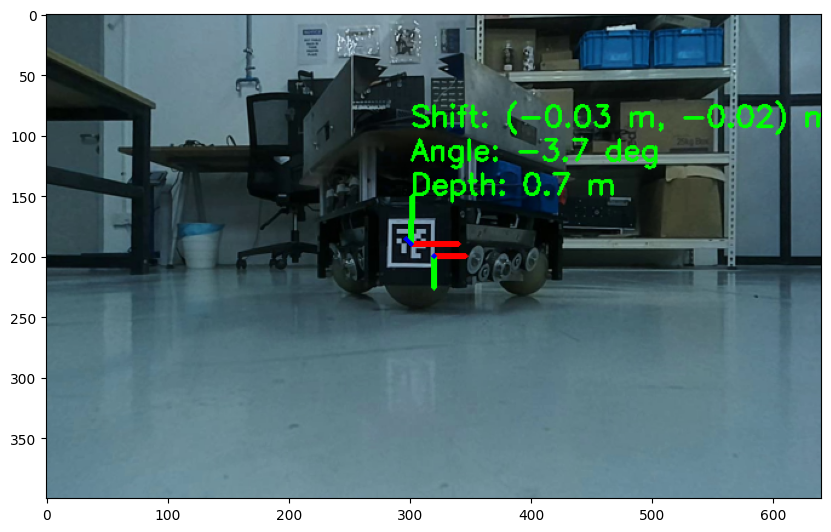

In [7]:
_ = plt.figure(figsize=(10, 10))

plt.imshow(annotated_rgb[..., ::-1])  